In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import keras
import os
import cv2
import numpy as np
import glob
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D , Dropout, Add, BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.preprocessing.image import load_img
from matplotlib import pyplot as plt
from keras.layers import concatenate

In [ ]:
#path with all the images
def read_images(path):
    os.chdir(path)
    images = []
    mat_imgs = []
    for file in sorted(glob.glob("*.jpg")):
        img = cv2.imread(file)
        mat_im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        #print(file)
        images.append(np.array(img))
        mat_imgs.append(np.array(mat_im))
    return images,mat_imgs

In [ ]:
def read_masks(path):
    l = os.listdir(path)
    lsorted = sorted(l,key=lambda x: int(os.path.splitext(x)[0]))
    images = []
    for file in lsorted:
        img = cv2.imread(path + file)
        #mat_im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        #print(file)
        images.append(np.array(img))
        #mat_imgs.append(mat_im)
    return images

In [ ]:
imgs,mat = read_images('/content/gdrive/MyDrive/Drions_Data/Unlabeled_Images')

In [ ]:
masks,mat_masks = read_images('/content/gdrive/MyDrive/Drions_Data/Masks')

In [ ]:
new_masks = []
for mask in masks:
  new_masks.append(cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY))

In [ ]:
imgs[0].shape

(576, 720, 3)

In [ ]:
new_masks[7].shape

(576, 720)

In [ ]:
# Reshaping
images = []
labels = []
new_labels = []
for i in range(len(imgs)):
  # dimension are inverted
  # shapes need to be divisible by 256 as the network goes 8 layers deep(2^8)
  # resizing to the closest multiple of 256
  images.append(cv2.resize(imgs[i],(768,512), interpolation = cv2.INTER_AREA))    #576,384
  labels.append(cv2.resize(masks[i],(768,512), interpolation = cv2.INTER_AREA))   #512*704
  new_labels.append(cv2.resize(new_masks[i],(768,512), interpolation = cv2.INTER_AREA))

In [ ]:
print(images[0].shape)
print(new_labels[0].shape)
print(len(images))

(512, 768, 3)
(512, 768)
234


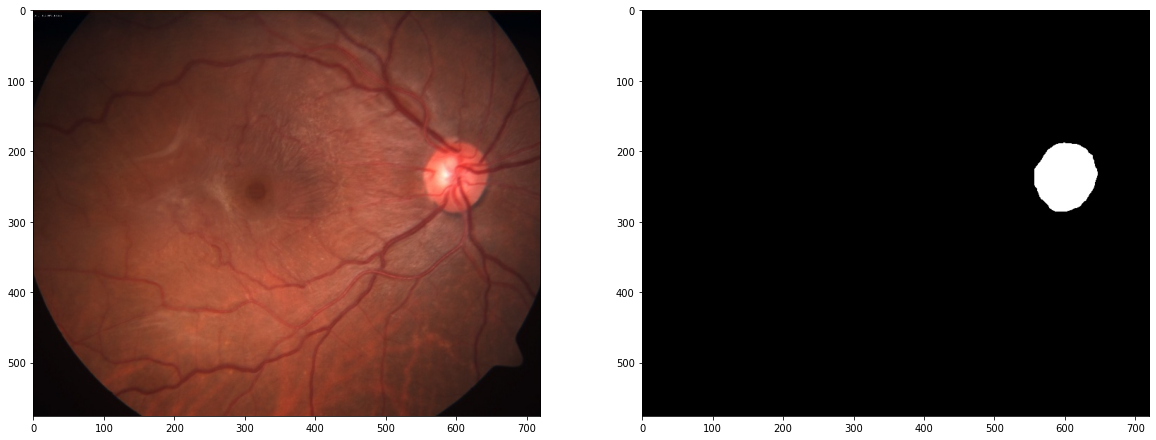

In [ ]:
i = 7
fig,ax = plt.subplots(1,2,figsize = (20,16))
ax[0].imshow(mat[i])
ax[1].imshow(new_masks[i],cmap  = 'gray')

In [ ]:
X_train = np.array(images[:200])/255
X_test = np.array(images[200:])/255
Y_train = np.array(new_labels[:200])/255
Y_test = np.array(new_labels[200:])/255

In [ ]:
print(images[7].shape)
print(new_labels[7].shape)

(512, 768, 3)
(512, 768)


In [ ]:
def encoder(X,output):
  x = Conv2D(output,(3,3),activation = 'relu', padding = 'same',dilation_rate=3)(X)
  x = BatchNormalization(axis = -1)(x)
  x = Conv2D(output,(3,3),activation = 'relu', padding = 'same',dilation_rate=2)(x)
  x = BatchNormalization(axis = -1)(x)
  x = Conv2D(output,(3,3),activation = 'relu',padding = 'same')(x)
  x = BatchNormalization(axis = -1)(x)
  
  temp = x
  x = MaxPooling2D((2,2))(x)
  return x, temp

In [ ]:
def decoder(X,output,feature):
  x = Conv2D(output, (3,3),activation = 'relu', padding = 'same')(X)
  x = BatchNormalization(axis = -1)(x)
  x = UpSampling2D((2,2))(x)
  x = Add()([feature,x])
  x = Conv2D(output,(3,3),activation = 'relu',padding = 'same',dilation_rate = 2)(x)
  x = BatchNormalization(axis = -1)(x)
  x = Conv2D(output,(3,3),activation = 'relu',padding = 'same',dilation_rate = 3)(x)
  x = BatchNormalization(axis = -1)(x)

  return x

In [ ]:
def func_auto(intput_shape):
  
  X_input = Input(input_shape)
  
  #encoder
  x,temp1 = encoder(X_input,16)
  x,temp2 = encoder(x,16*2)
  x,temp3 = encoder(x,16*3)
  x,temp4 = encoder(x,16*4)
  x,temp5 = encoder(x,16*5)
  x,temp6 = encoder(x,16*6)
  x,temp7 = encoder(x,16*7)
  x,temp8 = encoder(x,16*8)
  
  #decoder
  x = decoder(x,16*8,temp8)
  x = decoder(x,16*7,temp7)
  x = decoder(x,16*6,temp6)
  x = decoder(x,16*5,temp5)
  x = decoder(x,16*4,temp4)
  x = decoder(x,16*3,temp3)
  x = decoder(x,16*2,temp2)
  x = decoder(x,16,temp1)

  decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)


  model = Model(inputs = X_input, outputs = decoded, name = 'func_auto')
  return model

In [ ]:
input_shape = (512,768,3)
model = func_auto(input_shape)

In [ ]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy')

In [ ]:
model.summary()

Model: "func_auto"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 768, 3) 0                                            
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 512, 768, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 512, 768, 16) 64          conv2d_50[0][0]                  
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 512, 768, 16) 2320        batch_normalization_40[0][0]     
__________________________________________________________________________________________

In [ ]:
model.fit(X_train, Y_train,
                epochs=100,
                batch_size=16,
                shuffle=True)

Epoch 1/100
13/13 [==============================] - 23s 1s/step - loss: 0.4817
Epoch 2/100
13/13 [==============================] - 19s 1s/step - loss: 0.2383
Epoch 3/100
13/13 [==============================] - 18s 1s/step - loss: 0.1692
Epoch 4/100
13/13 [==============================] - 18s 1s/step - loss: 0.1381
Epoch 5/100
13/13 [==============================] - 18s 1s/step - loss: 0.1175
Epoch 6/100
13/13 [==============================] - 18s 1s/step - loss: 0.0991
Epoch 7/100
13/13 [==============================] - 18s 1s/step - loss: 0.0876
Epoch 8/100
13/13 [==============================] - 18s 1s/step - loss: 0.0771
Epoch 9/100
13/13 [==============================] - 18s 1s/step - loss: 0.0684
Epoch 10/100
13/13 [==============================] - 18s 1s/step - loss: 0.0625
Epoch 11/100
13/13 [==============================] - 18s 1s/step - loss: 0.0582
Epoch 12/100
13/13 [==============================] - 18s 1s/step - loss: 0.0522
Epoch 13/100
13/13 [=================

In [ ]:
predictions = model.predict(X_test)

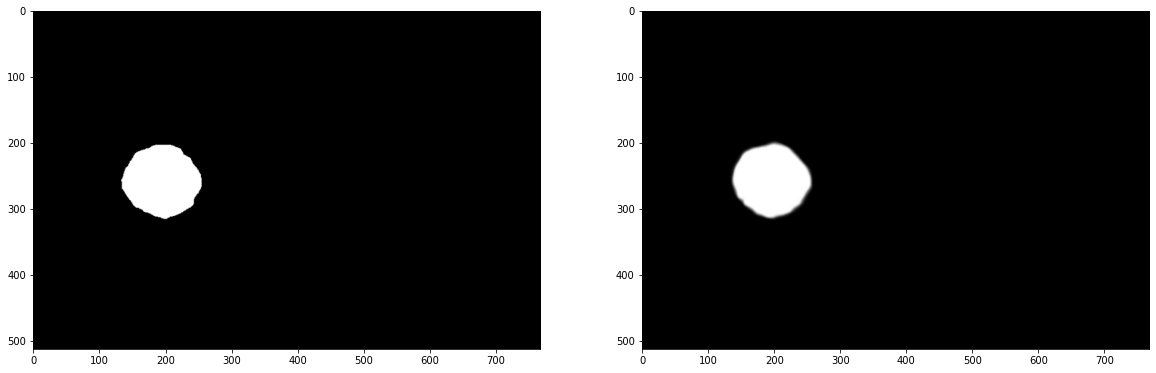

In [ ]:
i = 10

fig,ax = plt.subplots(1,2,figsize = (20,16))
ax[0].imshow(Y_test[i], cmap = 'gray')
ax[1].imshow(predictions[i].reshape(Y_test[i].shape),cmap = 'gray')

In [ ]:
T = 0
F = 0
idx = 19
k = predictions[idx]
for i in range(predictions[idx].shape[0]):
  for j in range(predictions[idx].shape[1]):
    if(abs(k[i][j][0] - Y_test[idx][i][j][0]) < 0.1):
      T = T+1
    else:
      F = F+1

In [ ]:
T/(T+F)

0.9967676798502604

In [ ]:
test_imgs,test_mat = read_images('/content/gdrive/MyDrive/auto-encoder/images')

In [ ]:
test_labels = read_masks('/content/gdrive/MyDrive/auto-encoder/masks/')

In [ ]:
test_im = []
test_im_mat = []
test_lab = []
for i in range(len(test_imgs)):
  test_im.append(cv2.resize(test_imgs[i],(768,512), interpolation = cv2.INTER_AREA))    #576,384
  test_im_mat.append(cv2.resize(test_mat[i],(768,512), interpolation = cv2.INTER_AREA))
  lab=cv2.resize(test_labels[i],(768,512), interpolation = cv2.INTER_AREA)      #512*704
  test_lab.append(cv2.cvtColor(lab,cv2.COLOR_BGR2GRAY))

In [ ]:
test_lab = np.array(test_lab)/255
test_im = np.array(test_im)/255

In [ ]:
test_pred = model.predict(test_im)